In [41]:
import numpy as np
from scipy import io
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
data = []
labels = []
path = "./Raw_data/"
for label in range(5):
    print(label)
    f_path = os.path.join(os.path.join(path, str(label)), "fft_data_final.mat")
    data.append(io.loadmat(f_path)["fft_data_final"])
    labels.extend([label]*data[-1].shape[2])

data = np.concatenate(data, axis=2)
labels = np.array(labels)

0
1
2
3
4


In [7]:
data.shape

(866, 256, 5000)

In [8]:
labels.shape

(5000,)

In [9]:
temp = np.where(data[0, 0, :] != 0)
train_test_data = data[:, :, temp[0]]
train_test_labels = labels[temp[0]]


In [10]:
import matplotlib.pyplot as plt

In [11]:
background_img = np.mean(train_test_data[:, :, 0:200], axis=2)

In [12]:
train_test_labels[450]

2

In [13]:
max_inds = np.unravel_index(np.argsort(train_test_data[:, :, 500] - background_img, axis=None), background_img.shape)

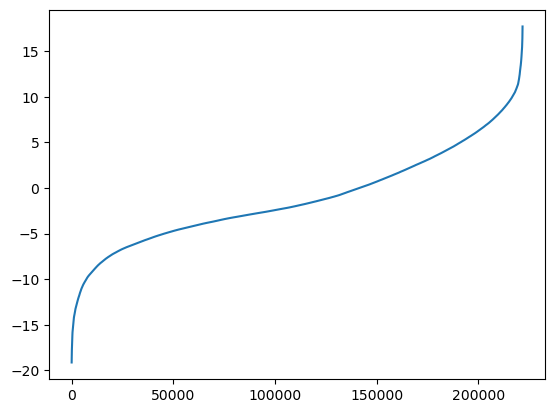

In [14]:
plt.plot(range(866*256), (train_test_data[:, :, 500] - background_img)[max_inds[0], max_inds[1]])

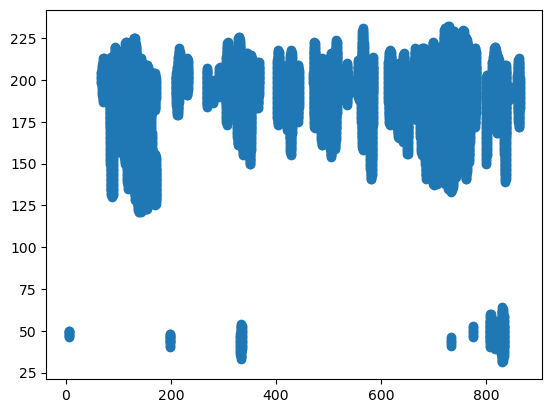

In [15]:
plt.scatter(max_inds[0][-22000:], max_inds[1][-22000:])

In [106]:
train_test_data = train_test_data - background_img[:, :, np.newaxis]

In [123]:
import torch
from sklearn.model_selection import train_test_split


train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).float()
test_labels = torch.from_numpy(test_labels).float()
train_labels = F.one_hot(train_labels, 5)
test_labels = F.one_hot(test_labels, 5)

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



RuntimeError: one_hot is only applicable to index tensor.

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*6*2, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 16*6*2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = Net()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_data = []
test_loss_data = [] 
temp_out = 10000 
num_epochs = 20

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        test_loss = torch.nn.functional.mse_loss(out, test_labels)
        print("test loss - {}".format(torch.nn.functional.mse_loss(out, test_labels)))
    
    train_loss = running_loss / len(train_loader) 
#     if (train_loss > temp_out):
#         break
    temp_out = train_loss 
    
    # Print statistics
    train_loss_data.append(temp_out)
    test_loss_data.append(test_loss)
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

print('Finished Training')


tensor(0.4865, grad_fn=<MseLossBackward0>)
tensor(0.1858, grad_fn=<MseLossBackward0>)
tensor(0.6237, grad_fn=<MseLossBackward0>)
tensor(0.3464, grad_fn=<MseLossBackward0>)
tensor(0.3110, grad_fn=<MseLossBackward0>)
tensor(0.2004, grad_fn=<MseLossBackward0>)
tensor(0.2240, grad_fn=<MseLossBackward0>)
tensor(0.2020, grad_fn=<MseLossBackward0>)
tensor(0.1208, grad_fn=<MseLossBackward0>)
tensor(0.1703, grad_fn=<MseLossBackward0>)
tensor(0.1516, grad_fn=<MseLossBackward0>)
tensor(0.1221, grad_fn=<MseLossBackward0>)
tensor(0.1603, grad_fn=<MseLossBackward0>)
tensor(0.2100, grad_fn=<MseLossBackward0>)
tensor(0.1851, grad_fn=<MseLossBackward0>)
tensor(0.0698, grad_fn=<MseLossBackward0>)
tensor(0.1577, grad_fn=<MseLossBackward0>)
tensor(0.1008, grad_fn=<MseLossBackward0>)
tensor(0.2214, grad_fn=<MseLossBackward0>)
tensor(0.2796, grad_fn=<MseLossBackward0>)
tensor(0.1901, grad_fn=<MseLossBackward0>)
tensor(0.1112, grad_fn=<MseLossBackward0>)
tensor(0.1925, grad_fn=<MseLossBackward0>)
tensor(0.16

/var/folders/nv/vcg57cz17bdd5g0wq6rqp36h0000gn/T/ipykernel_37133/3600537842.py:60: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = torch.nn.functional.mse_loss(out, test_labels)
/var/folders/nv/vcg57cz17bdd5g0wq6rqp36h0000gn/T/ipykernel_37133/3600537842.py:61: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print("test loss - {}".format(torch.nn.functional.mse_loss(out, test_labels)))


test loss - 0.172721266746521
[Epoch 1] loss: 0.216
tensor(0.1471, grad_fn=<MseLossBackward0>)
tensor(0.2122, grad_fn=<MseLossBackward0>)
tensor(0.2107, grad_fn=<MseLossBackward0>)
tensor(0.1220, grad_fn=<MseLossBackward0>)
tensor(0.1383, grad_fn=<MseLossBackward0>)
tensor(0.1208, grad_fn=<MseLossBackward0>)
tensor(0.1550, grad_fn=<MseLossBackward0>)
tensor(0.2293, grad_fn=<MseLossBackward0>)
tensor(0.1355, grad_fn=<MseLossBackward0>)
tensor(0.1990, grad_fn=<MseLossBackward0>)
tensor(0.0977, grad_fn=<MseLossBackward0>)
tensor(0.1953, grad_fn=<MseLossBackward0>)
tensor(0.2097, grad_fn=<MseLossBackward0>)
tensor(0.1232, grad_fn=<MseLossBackward0>)
tensor(0.1100, grad_fn=<MseLossBackward0>)
tensor(0.1913, grad_fn=<MseLossBackward0>)
tensor(0.1370, grad_fn=<MseLossBackward0>)
tensor(0.1355, grad_fn=<MseLossBackward0>)
tensor(0.1570, grad_fn=<MseLossBackward0>)
tensor(0.1563, grad_fn=<MseLossBackward0>)
tensor(0.1989, grad_fn=<MseLossBackward0>)
tensor(0.1349, grad_fn=<MseLossBackward0>)
te

tensor(0.1539, grad_fn=<MseLossBackward0>)
tensor(0.1527, grad_fn=<MseLossBackward0>)
tensor(0.1918, grad_fn=<MseLossBackward0>)
tensor(0.1922, grad_fn=<MseLossBackward0>)
tensor(0.0710, grad_fn=<MseLossBackward0>)
tensor(0.2941, grad_fn=<MseLossBackward0>)
tensor(0.1718, grad_fn=<MseLossBackward0>)
tensor(0.1022, grad_fn=<MseLossBackward0>)
tensor(0.1882, grad_fn=<MseLossBackward0>)
tensor(0.2039, grad_fn=<MseLossBackward0>)
tensor(0.1728, grad_fn=<MseLossBackward0>)
tensor(0.1288, grad_fn=<MseLossBackward0>)
tensor(0.1554, grad_fn=<MseLossBackward0>)
tensor(0.1536, grad_fn=<MseLossBackward0>)
tensor(0.1528, grad_fn=<MseLossBackward0>)
tensor(0.0902, grad_fn=<MseLossBackward0>)
tensor(0.1102, grad_fn=<MseLossBackward0>)
tensor(0.2400, grad_fn=<MseLossBackward0>)
tensor(0.1100, grad_fn=<MseLossBackward0>)
test loss - 0.17418654263019562
[Epoch 9] loss: 0.161
tensor(0.1585, grad_fn=<MseLossBackward0>)
tensor(0.1982, grad_fn=<MseLossBackward0>)
tensor(0.1529, grad_fn=<MseLossBackward0>)


tensor(0.1105, grad_fn=<MseLossBackward0>)
tensor(0.2451, grad_fn=<MseLossBackward0>)
tensor(0.1342, grad_fn=<MseLossBackward0>)
tensor(0.1370, grad_fn=<MseLossBackward0>)
tensor(0.1399, grad_fn=<MseLossBackward0>)
tensor(0.2028, grad_fn=<MseLossBackward0>)
tensor(0.2315, grad_fn=<MseLossBackward0>)
tensor(0.1125, grad_fn=<MseLossBackward0>)
tensor(0.2025, grad_fn=<MseLossBackward0>)
tensor(0.2027, grad_fn=<MseLossBackward0>)
tensor(0.1565, grad_fn=<MseLossBackward0>)
tensor(0.2045, grad_fn=<MseLossBackward0>)
test loss - 0.16689151525497437
[Epoch 16] loss: 0.161
tensor(0.1879, grad_fn=<MseLossBackward0>)
tensor(0.1883, grad_fn=<MseLossBackward0>)
tensor(0.1535, grad_fn=<MseLossBackward0>)
tensor(0.1885, grad_fn=<MseLossBackward0>)
tensor(0.1712, grad_fn=<MseLossBackward0>)
tensor(0.0999, grad_fn=<MseLossBackward0>)
tensor(0.1902, grad_fn=<MseLossBackward0>)
tensor(0.1132, grad_fn=<MseLossBackward0>)
tensor(0.1528, grad_fn=<MseLossBackward0>)
tensor(0.1323, grad_fn=<MseLossBackward0>)

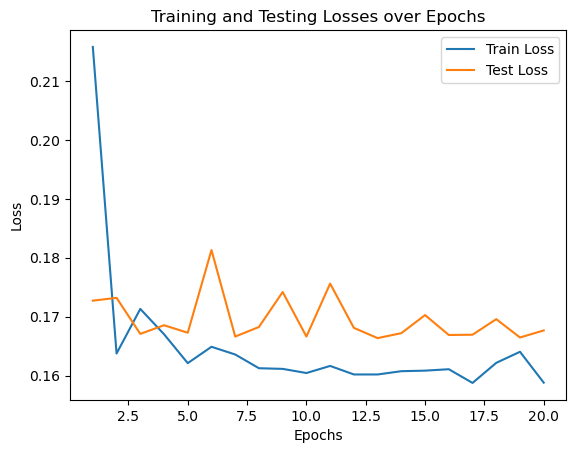

In [109]:
plt.plot(range(1, len(train_loss_data) + 1), train_loss_data, label='Train Loss')
plt.plot(range(1, len(test_loss_data) + 1), test_loss_data, label='Test Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses over Epochs')
plt.legend()

# Displaying the plot
plt.show()

In [125]:
out = model(test_data[:, :, :, :])

pred_labels[pred_labels < 0.5] = 0
pred_labels[(pred_labels > 0.5) & (pred_labels < 1.5) ] = 1
pred_labels[(pred_labels > 1.5) & (pred_labels < 2.5) ] = 2
pred_labels[(pred_labels > 2.5) & (pred_labels < 3.5) ] = 3
pred_labels[(pred_labels > 3.5) ] = 4

# for i in range(len(pred_labels)): 
#     pred_labels[i] = round(pred_labels[i])
# actual_labels = torch.argmax(test_labels, axis=1)
print(test_labels)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1.])


In [ ]:
pred_labels

tensor([[1.9946],
        [1.9381],
        [2.0490],
        [2.0132],
        [2.0731],
        [1.9747],
        [2.3455],
        [1.5832],
        [1.5746],
        [1.9924],
        [1.7009],
        [2.1263],
        [2.0902],
        [1.9398],
        [1.8373],
        [2.0735],
        [1.8612],
        [2.2959],
        [1.7469],
        [2.0629],
        [2.2381],
        [2.1998],
        [1.9930],
        [2.0810],
        [2.0651],
        [2.1310],
        [2.1946],
        [1.9836],
        [1.9977],
        [1.8988],
        [1.7934],
        [2.1572],
        [1.9222],
        [1.8637],
        [2.1985],
        [1.8209],
        [1.8770],
        [2.1140],
        [2.2560],
        [1.7865],
        [1.8558],
        [1.9489],
        [1.7367],
        [1.9735],
        [2.0173],
        [1.8706],
        [1.9721],
        [1.8558],
        [2.2498],
        [1.7460],
        [1.9711],
        [2.3474],
        [1.7311],
        [2.0285],
        [1.7981],
        [2

In [115]:
# use cross entropy loss

from sklearn.model_selection import train_test_split
import torch.nn.functional as F

train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).to(torch.int64)
test_labels = torch.from_numpy(test_labels).to(torch.int64)

train_labels = F.one_hot(train_labels, 5)
test_labels = F.one_hot(test_labels, 5)

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



In [60]:
# Run this code for different model types 
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*6*2, 16)
        self.fc2 = nn.Linear(16, 5)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 32*6*2)
        x = torch.relu(self.fc1(x))
        x = self.sm(self.fc2(x))
        return x

# Instantiate the model
model = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_data = []
test_loss_data = [] 
temp_out = 10000 
num_epochs = 100
# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        test_loss = criterion(out, test_labels.float())
        print("test loss - {}".format(criterion(out, test_labels.float())))


    train_loss = running_loss / len(train_loader) 
    if (train_loss > temp_out):
        break
    temp_out = train_loss 
    
    # Print statistics
    train_loss_data.append(temp_out)
    test_loss_data.append(test_loss)
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
    
print('Finished Training')


tensor(1.6104, grad_fn=<DivBackward1>)
tensor(1.6092, grad_fn=<DivBackward1>)
tensor(1.5965, grad_fn=<DivBackward1>)
tensor(1.6075, grad_fn=<DivBackward1>)
tensor(1.5581, grad_fn=<DivBackward1>)
tensor(1.5603, grad_fn=<DivBackward1>)
tensor(1.5029, grad_fn=<DivBackward1>)
tensor(1.5373, grad_fn=<DivBackward1>)


KeyboardInterrupt: 

In [34]:
out = model(test_data)

In [35]:
pred_labels = torch.argmax(out, axis=1)

In [36]:
actual_labels = torch.argmax(test_labels, axis=1)

34
24
21
36
38
200


4.78

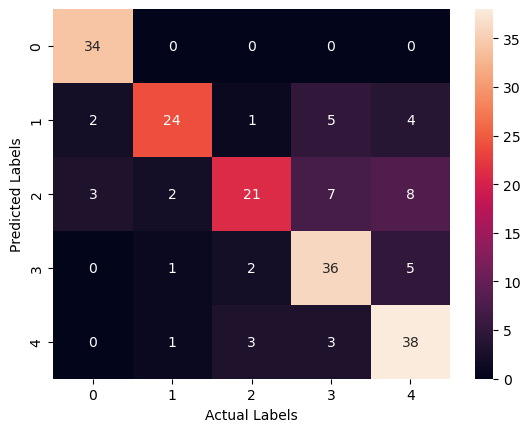

In [58]:
import seaborn as sns
cf_matrix = confusion_matrix(actual_labels, pred_labels)

s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
for i in range(5):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy


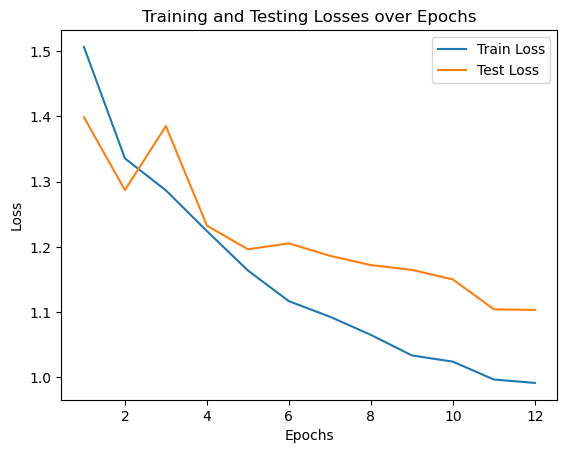

In [59]:

plt.plot(range(1, len(train_loss_data) + 1), train_loss_data, label='Train Loss')
plt.plot(range(1, len(test_loss_data) + 1), test_loss_data, label='Test Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses over Epochs')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
test_labels.shape

torch.Size([200, 5])

In [ ]:
# see data

In [13]:
img = None
for i in range(1000):
    fig = plt.figure()
    plt.imshow(train_test_data[:, :, i])
    fig.savefig("./fft_images/{}.png".format(i))
    #plt.draw()

NameError: ignored

In [ ]:
# people detection (binary)

In [65]:
from sklearn.model_selection import train_test_split

train_test_labels = train_test_labels.astype(int)
train_test_labels[train_test_labels > 0] = 1
train_data, test_data, train_labels, test_labels = train_test_split(np.transpose(train_test_data[:, :, :, np.newaxis], (2, 3, 0, 1)), train_test_labels.astype(int), test_size=0.2)

# Convert the training and testing data and targets to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(train_labels).float()
test_labels = torch.from_numpy(test_labels).float()

# Define a PyTorch dataset and dataloader for the training data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)



In [68]:
# people detection 
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding="same")
        self.pool1 = nn.MaxPool2d(5, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, (5, 5), padding="same")
        self.pool2 = nn.MaxPool2d(5, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, (5, 5), padding="same")
        self.pool3 = nn.MaxPool2d(5, 5)
        self.bn3 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*6*2, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.bn1(self.pool1(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool2(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool3(torch.relu(self.conv3(x))))
        x = x.view(-1, 16*6*2)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = x.flatten()
        return x

# Instantiate the model
model = Net()
print(model)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_data = []
test_loss_data = [] 
temp_out = 10000 
num_epochs = 100

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Define the loss function
        inputs, labels = data
        class_weights = torch.tensor([0.2]*32).to("cpu")
        class_weights[labels == 0] = 0.8
        criterion = nn.BCELoss(weight=class_weights)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        out = model(test_data)
        test_loss = torch.nn.functional.mse_loss(out, test_labels)
        print("test loss - {}".format(torch.nn.functional.mse_loss(out, test_labels)))

    train_loss = running_loss / len(train_loader) 
    if (train_loss > temp_out):
        break
    temp_out = train_loss 
    
    # Print statistics
    train_loss_data.append(temp_out)
    test_loss_data.append(test_loss)
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

print('Finished Training')


Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=192, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
tensor(0.2520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2093, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2595, grad_f

tensor(0.0074, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0082, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0035, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0048, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0204, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0029, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0032, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0035, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0120, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0033, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0052, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0086, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0074, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0046, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0115, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0071, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0044, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0031, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0222, grad_fn=<Bina

28
172
200


1.0

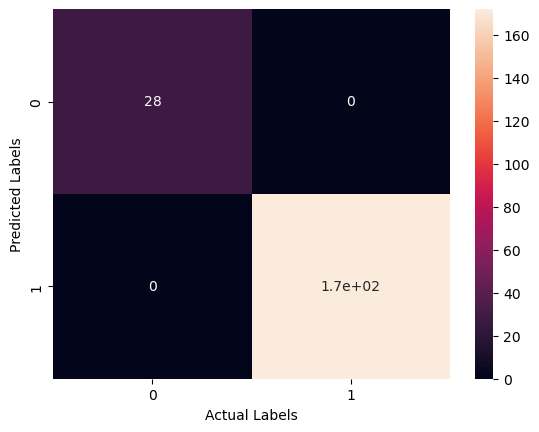

In [76]:
out = model(test_data)
out[out > 0.5] = 1
out[out < 0.5] = 0
import seaborn as sns
cf_matrix = confusion_matrix(test_labels.detach().numpy(), out.detach().numpy())

s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
true_reps = 0
for i in range(len(cf_matrix)):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy

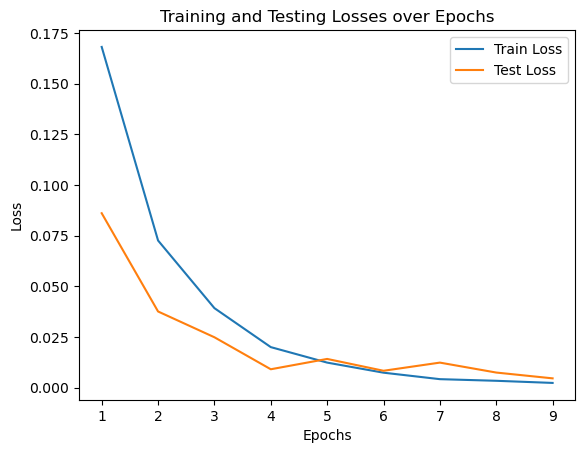

In [71]:
plt.plot(range(1, len(train_loss_data) + 1), train_loss_data, label='Train Loss')
plt.plot(range(1, len(test_loss_data) + 1), test_loss_data, label='Test Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses over Epochs')
plt.legend()

# Displaying the plot
plt.show()

In [73]:
# from torchvision.utils import save_image
# save_image(model, "model.png")

In [ ]:
out

tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
        0., 1.], grad_fn=<AsStridedBackward0>)

In [ ]:
test_labels

tensor([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
        1., 1.])

42
154
200


0.98

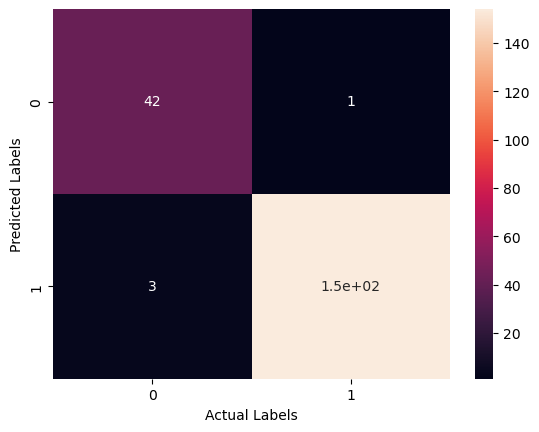

In [78]:
# Old data with 0.01 learning rate and limited epochs 
import seaborn as sns
hehe1 = np.array([[ 42,   1],
       [  3, 154]])

cf_matrix = hehe1
s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
true_reps = 0
for i in range(len(cf_matrix)):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy

43
25
25
33
34
200


0.8

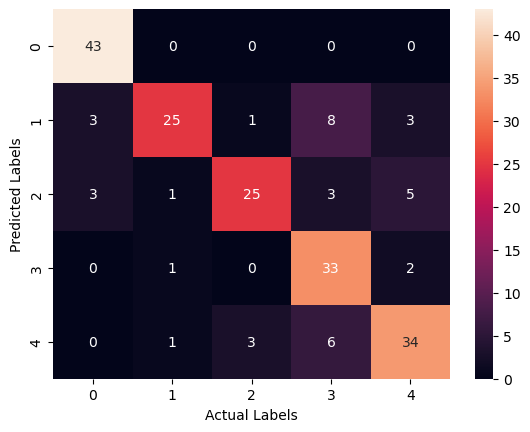

In [79]:
# Old data with 0.01 learning rate and limited epochs 
import seaborn as sns
hehe2 = np.array([[43,  0,  0,  0,  0],
       [ 3, 25,  1,  8,  3],
       [ 3,  1, 25,  3,  5],
       [ 0,  1,  0, 33,  2],
       [ 0,  1,  3,  6, 34]])
cf_matrix = hehe2
s = sns.heatmap(cf_matrix, annot=True)
s.set_xlabel('Actual Labels', fontsize=10)
s.set_ylabel('Predicted Labels', fontsize=10)
true_reps = 0
for i in range(len(cf_matrix)):
    print(cf_matrix[i][i])
    true_reps += cf_matrix[i][i]
total = sum(sum(cf_matrix))
print(total)
accuracy = (true_reps/total)
accuracy